# Directivity and S-parameters computation of patch antenna 

A rectangular patch antenna is a type of microstrip antenna consisting of a rectangular conductive patch placed on a dielectric substrate with a ground plane on the opposite side. These antennas are widely used in wireless communication applications due to their simple design, ease of fabrication, and low profile.

<img src="img/PatchAntenna.png" alt="Schematic of the patch antenna"  width="400"/>

In this notebook, we will demonstrate how to use Tidy3D to simulate a rectangular patch antenna [1] and compute key performance metrics. These include S-parameters using the [TerminalComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.TerminalComponentModeler.html), as well as directivity, axial ratio, and polarized far-field components using the [DirectivityMonitor](https://docs.flexcompute.com/projects/tidy3d/en/pre-2.8/api/_autosummary/tidy3d.DirectivityMonitor.html).


In [1]:
# Tidy3d import
import matplotlib.pyplot as plt

# External modules needed for this notebook
import numpy as np
import tidy3d as td

# Tidy3d plugin import
import tidy3d.plugins.smatrix as smatrix
from tidy3d.web import run

## Units and Frequency Settings

In Tidy3D, the default units are micrometers (µm) and Hertz (Hz). In the following, we introduce a scaling factor to convert the default unit of micrometers to millimeters (mm), which is more commonly used in antenna simulations.

In [2]:
# Scaling used for millimeters
mm = 1e3

# Frequency range
freq_start = 0.5e9
freq_stop = 20e9

freq0 = (freq_start + freq_stop) / 2  # Centeral frequency
freqs_target = [7.5e9, 10e9]  # Target frequencies (in Hz) for computing directivity and axial ratio
fwidth = freq_stop - freq_start  # Bandwidth

# Wavelength of centeral frequency in vacuum
wavelength0 = td.C_0 / freq0

# Frequency sweep for S-parameters
freqs = np.linspace(freq_start, freq_stop, 200)

## Materials

We use a simple dielectric substrate with a relative permittivity of 2.2 and `PEC2D`, a thickness-free perfect electric conductor (PEC) medium to represent the conducting materials in the antenna.


In [3]:
# Material present
air = td.Medium()
eps_r = 2.2
sub_medium = td.Medium(permittivity=eps_r)
PEC = td.PEC2D  # Thickness-free PEC medium

## Building Geometry and Structures

We follow the parameters outlined in [1] to create the corresponding patch antenna step-by-step. Boolean operations on geometries can be applied using [ClipOperation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ClipOperation.html).

In [4]:
# Substrate parameters
sub_x = 23.34 * mm
sub_y = 40 * mm
sub_z = 0.794 * mm

# Patch parameters
patch_x = 12.45 * mm
patch_y = 16 * mm

# Feedline parameters
feed_x = 2.46 * mm
feed_y = 20 * mm
feed_offset = 2.09 * mm

# Define substrate structure
substrate = td.Structure(
    geometry=td.Box(center=[0, 0, 0], size=[sub_x, sub_y, sub_z]),
    medium=sub_medium,
)

# Define ground plane structure and assign the material by PEC
ground_plane = td.Structure(
    geometry=td.Box.from_bounds(
        [-sub_x / 2, -sub_y / 2, -sub_z / 2], [sub_x / 2, sub_y / 2, -sub_z / 2]
    ),
    medium=PEC,
)

# Define patch geometry
patch_geometry = td.Box.from_bounds(
    [-patch_x / 2, -sub_y / 2 + feed_y, sub_z / 2],
    [patch_x / 2, -sub_y / 2 + feed_y + patch_y, sub_z / 2],
)

# Define feedline geometry
feedline_geometry = td.Box.from_bounds(
    [-patch_x / 2 + feed_offset, -sub_y / 2, sub_z / 2],
    [-patch_x / 2 + feed_offset + feed_x, -sub_y / 2 + feed_y, sub_z / 2],
)

# Unionize the patch and feedline
radiating_geometry = td.ClipOperation(
    operation="union", geometry_a=patch_geometry, geometry_b=feedline_geometry
)

# Define radiating structure and assign conductive patch by PEC
radiating_structure = td.Structure(
    geometry=radiating_geometry,
    medium=PEC,
)

# List of structures for the simulation.
# Arrange structures in the following order: dielectric first, followed by PEC.
# This ensures that PEC override dielectric at the interfaces.
# Reversing the order may lead to inaccurate solutions.
structures_list = [substrate, ground_plane, radiating_structure]

## Define Monitors

A `FieldMonitor` is used to observe the field distribution on the antenna patch. 
To obtain radiation characteristics such as directivity, axial ratio, and polarized far fields, use a `DirectivityMonitor`. 
The `DirectivityMonitor` captures far-field information through a near-to-far field transformation.

In [5]:
# Field monitor to view the electromagnetic fields in the patch plane
monitor_field = td.FieldMonitor(
    center=(0, 0, sub_z / 2),
    size=(td.inf, td.inf, 0),
    freqs=freqs_target,
    name="field",
)

# Define observation parameters used for DirectitiviyMonitor
theta = np.linspace(-np.pi, np.pi, 200)
phi = np.linspace(0, np.pi, 100)

# We define a DirectivityMonitor to obtain radiation characteristics such as directivity, axial ratio and polarized far fields.
monitor_directivity = td.DirectivityMonitor(
    center=[0, 0, 0],
    size=(
        30 * mm,
        45 * mm,
        4 * mm,
    ),  # We introduce a monitor box to enclose the whole structure of interest
    freqs=freqs_target,
    name="radiation",
    phi=list(phi),
    theta=list(theta),
    far_field_approx=True,  # Far-field approximation is suitable for most cases. For more accurate far-field projections, set far_field_approx=False.
)

10:11:31 CEST WARNING: ℹ️ ⚠️ RF simulations are subject to new license            
              requirements in the future. You have instantiated at least one    
              RF-specific component.                                            

## Boundaries

Perfectly Matched Layers (PMLs) are applied in all directions to simulate an infinitely large domain.

In [6]:
# PML wavelength at 10 GHz
wl_pml = wavelength0

# Quarter wavelength (at 10 GHz) padding on each side
sim_x = sub_x + wl_pml / 2
sim_y = sub_y + wl_pml / 2
sim_z = sub_z + wl_pml / 2

# Truncate the computational domain by PMLs
boundary_spec = td.BoundarySpec(
    x=td.Boundary.pml(),
    y=td.Boundary.pml(),
    z=td.Boundary.pml(),
)

## Create Simulation Object

Create a simulation object that includes all the modules we have defined. Note that the excitation (source) is not defined here and will be introduced by as a lumped port.


In [7]:
# Create the simulation object
sim = td.Simulation(
    center=[0, 0, 0],
    size=[sim_x, sim_y, sim_z],
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=20,  # The largest cell size is set to 20 cells per smallest wavelength.
        wavelength=td.C_0 / freq_stop,  # Smallest wavelength to resolve
    ),
    structures=structures_list,
    sources=[],  # Sources will be added by TerminalComponentModeler
    monitors=[monitor_directivity, monitor_field],
    run_time=70 * (sub_y / td.C_0),
    boundary_spec=boundary_spec,
    plot_length_units="mm",  # This option will make plots default to units of millimeters.
)

              WARNING:  ℹ️ ⚠️ RF simulations are subject to new license           
              requirements in the future. You are using RF-specific components  
              in this simulation.                                               
               - Contains monitors defined for RF wavelengths.                  

## Define Lumped Port (Excitation) and TerminalComponentModeler

A `LumpedPort` is a commonly used excitation port in RF simulations. It consists of a lumped resistor at the port and a uniform current source to excite the structure.
The `TerminalComponentModeler` is used to combine the defined simulation object with the lumped port to compute S-parameters.


In [8]:
# Define the port impedance
port_impedance = 50

# Setup a LumpedPort for the TerminalComponentModeler, which is needed
# to end the port with a matched load as well as providing a source for the simulation.
port = smatrix.LumpedPort(
    center=[-patch_x / 2 + feed_offset + feed_x / 2, -sub_y / 2, 0],
    size=[feed_x, 0, sub_z],
    voltage_axis=2,
    name="lumped_port",
    impedance=port_impedance,
)

# We integrate the base simulation with the LumpedPort using the TerminalComponentModeler.
# This allows us to compute scattering parameters and extract any additional data needed from the simulation.
modeler = smatrix.TerminalComponentModeler(
    simulation=sim,
    ports=[port],
    freqs=freqs,
    verbose=True,
    remove_dc_component=False,  # Include DC component for more accuracy at low frequencies
)

## Examine Structures and Mesh

Before running the simulation, it is advisable to inspect the created structure and mesh. 
Here, we examine the structure along its propagation direction and the cross-section at the terminated end of the feedline, which includes the location of the lumped element.

              WARNING:  ℹ️ ⚠️ RF simulations are subject to new license           
              requirements in the future. You are using RF-specific components  
              in this simulation.                                               
               - Contains a 'LumpedElement'.                                    
               - Contains monitors defined for RF wavelengths.                  

              WARNING: Structure at structures[0] was detected as being less    
              than half of a central wavelength from a PML on side x-min. To    
              avoid inaccurate results or divergence, please increase gap       
              between any structures and PML or fully extend structure through  
              the pml.                                                          

              WARNING: Suppressed 17 WARNING messages.                          

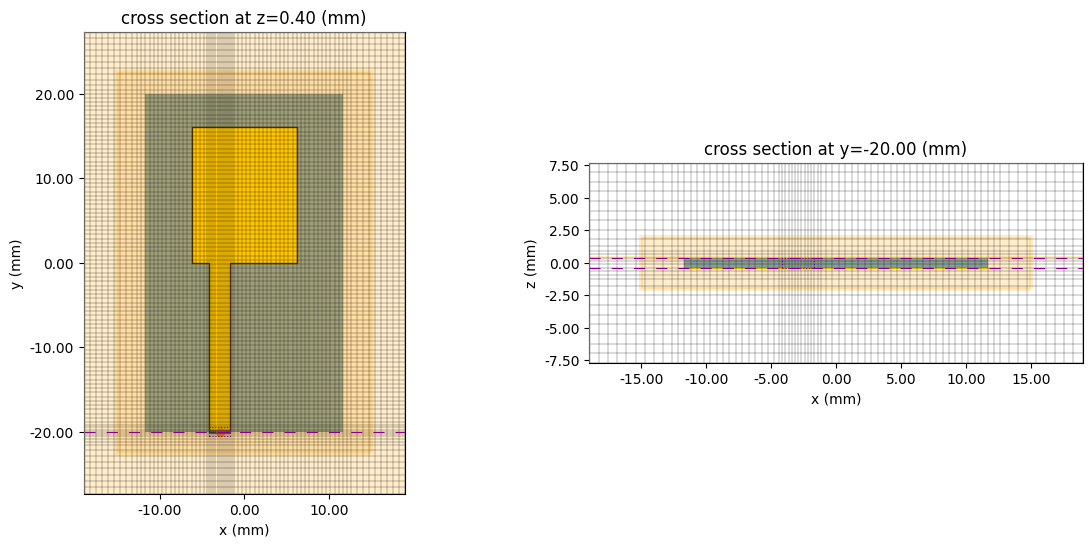

In [9]:
sim_temp = list(modeler.sim_dict.values())[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Examine the structure and mesh in the x-y plane
sim_temp.plot(
    z=sub_z / 2,
    ax=ax1,
    hlim=[-sim_x / 2, sim_x / 2],
    vlim=[-sim_y / 2, sim_y / 2],
    monitor_alpha=0.2,
)
sim_temp.plot_grid(z=sub_z / 2, ax=ax1, hlim=[-sim_x / 2, sim_x / 2], vlim=[-sim_y / 2, sim_y / 2])

# Examine the structure and mesh in the x-z plane
sim_temp.plot(
    y=-sub_y / 2 + 2 * mm,
    ax=ax2,
    hlim=[-sim_x / 2, sim_x / 2],
    vlim=[-sim_z / 2, sim_z / 2],
    monitor_alpha=0.2,
)
sim_temp.plot_grid(y=-sub_y / 2, ax=ax2, hlim=[-sim_x / 2, sim_x / 2], vlim=[-sim_z / 2, sim_z / 2])

# Show the plots
plt.show()

## Run simulation

In [10]:
td.config.logging_level = "ERROR"

batch_data = {
    task_name: run(simulation=simulation, task_name="AntennaCharacteristics")
    for task_name, simulation in modeler.sim_dict.items()
}

10:11:33 CEST Created task 'AntennaCharacteristics' with task_id                
              'fdve-5060434e-f2b3-4287-bfa6-f08bc5cbf4df' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=815278;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5060434e-f2b3-4287-bfa6-f08bc5cbf4df\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=260180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5060434e-f2b3-4287-bfa6-f08bc5cbf4df\taskId]8;;\]8;id=815278;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5060434e-f2b3-4287-bfa6-f08bc5cbf4df\=]8;;\]8;id=332935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5060434e-f2b3-4287-bfa6-f08bc5cbf4df\fdve]8;;\]8;id=815278;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5060434e-f2b3-4287-bfa6-f08bc5cbf4df\-5060434e-f2]8;;\
              ]8;id=815278;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5060434e-f2b3-4287-bfa6-f08bc5cbf4df\b3-4287-bfa6-f08bc5cbf4df']8;;\.

              Task folder: ]8;id=847788;https://tidy3d.simulation.cloud/folders/9b36e144-ddb6-41f8-8dd8-30b62b26a870\'default']8;;\.

Output()

10:11:35 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

10:11:36 CEST status = success

Output()

10:11:39 CEST loading simulation from simulation_data.hdf5

## Post processing: S-parameters

Output()

10:11:42 CEST Started working on Batch containing 1 tasks.

10:11:44 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

              Batch complete.

Output()

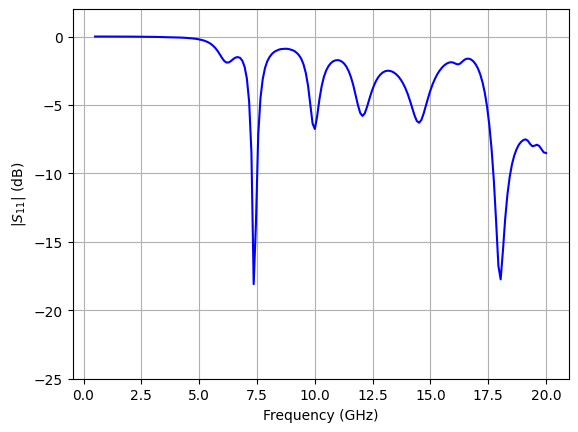

In [11]:
s_matrix = modeler._construct_smatrix()

plt.plot(
    s_matrix.f / 1e9,
    20 * np.log10(np.abs(s_matrix.isel(port_out=0, port_in=0).values.flatten())),
    "-b",
)

plt.xlabel("Frequency (GHz)")
plt.ylabel("$|S_{11}|$ (dB)")
plt.ylim(-25, 2)
plt.grid(True)
plt.show()

## Post processing: Field distributions

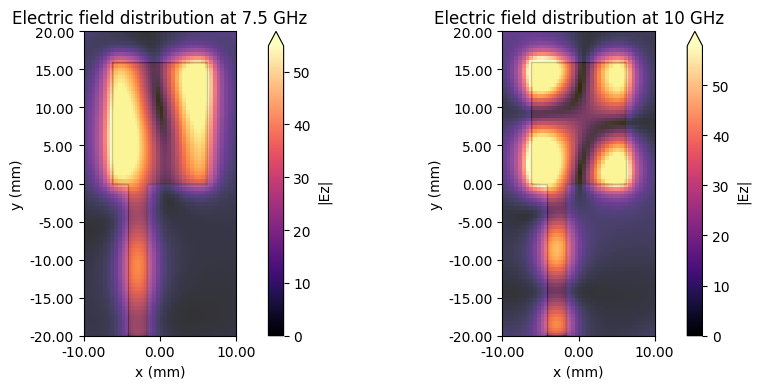

In [12]:
sim_data = batch_data["smatrix_lumped_port"]

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(11, 4))
sim_data.plot_field(
    field_monitor_name="field", field_name="Ez", val="abs", f=freqs_target[0], ax=ax1
)
ax1.set_xlim([-10 * mm, 10 * mm])
ax1.set_ylim([-20 * mm, 20 * mm])
ax1.set_title("Electric field distribution at 7.5 GHz")

sim_data.plot_field(
    field_monitor_name="field", field_name="Ez", val="abs", f=freqs_target[1], ax=ax2
)
ax2.set_xlim([-10 * mm, 10 * mm])
ax2.set_ylim([-20 * mm, 20 * mm])
ax2.set_title("Electric field distribution at 10 GHz");

## Post processing: Directivity

Directivity is a dimensionless quantity defined as the ratio of the radiation intensity in a given direction to the average radiation intensity over all directions. Mathematically, directivity $D(\theta, \phi)$ in a given direction $(\theta, \phi)$ is defined as:

$$
D(\theta, \phi) = \frac{{4\pi}U(\theta, \phi)}{{P_{\text{rad}}}}
$$

where:
- $U(\theta, \phi)$: Radiation intensity in direction $(\theta, \phi)$
- $P_{\text{rad}}$: Total radiated power

### **Computation**

1. **Radiation Intensity**:  
   Radiation intensity is given by:

   $$ U(\theta, \phi) = r^2 \cdot S_{\text{rad}}(\theta, \phi) $$

   where $S_{\text{rad}}(\theta, \phi)$ is the far-field Poynting vector magnitude, computed as:

   $$ S_{\text{rad}}(\theta, \phi) = \frac{1}{2} \cdot \text{Re}(E_\theta H_\phi^* - E_\phi H_\theta^*) $$

   Here, $E_\theta$ and $E_\phi$ are the electric field components in the far-field, $H_\phi^*$ and $H_\theta^*$ are the complex conjugates of the magnetic field components, and $r$ is the distance from the source.

2. **Total Radiated Power**:  
   The total radiated power is computed by integrating the Poynting vector over the sphere:

   $$ P_{\text{rad}} = \int_{0}^{2\pi} \int_{0}^{\pi} S_{\text{rad}}(\theta, \phi) r^2 \sin\theta \, d\theta \, d\phi $$

3. **Directivity**:  
   Directivity is determined by substituting $U(\theta, \phi)$ and $P_{\text{rad}}$ into the formula:

   $$ D(\theta, \phi) = \frac{{4\pi}U(\theta, \phi)}{{P_{\text{rad}}}}
 $$


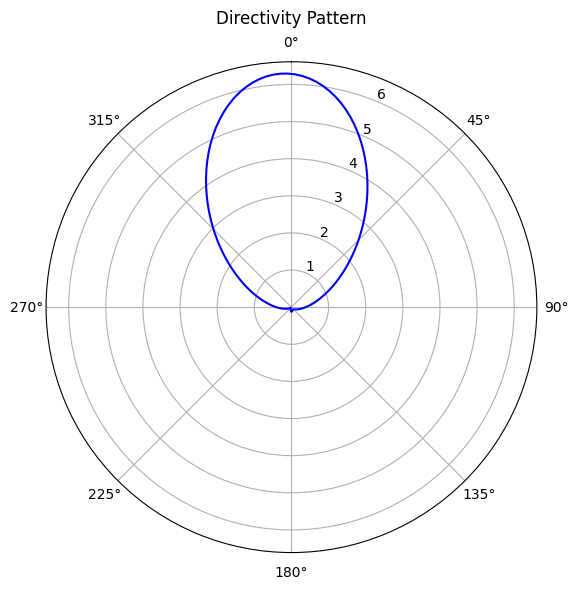

In [13]:
def log_value(values):
    return 20 * np.log10(values)


# Extract directivity
D_directivity = sim_data["radiation"].directivity.sel(f=freqs_target[0], phi=0, method="nearest")
D_directivity = np.squeeze(D_directivity)

# Create a single polar plot
fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax = fig.add_subplot(111, projection="polar")

# Plot directivity
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.plot(theta, D_directivity, "-b", label="Tidy3D")
ax.set_title("Directivity Pattern", va="bottom")

plt.show()

## Post processing:  Axial Ratio 

AR is a dimensionless quantity defined as the ratio of the major axis to the minor axis of the polarization ellipse
$$
AR = \frac{E_{\text{major}}}{E_{\text{minor}}}
$$

For a perfectly circularly polarized wave, $ AR = 1 $, corresponding to 0 dB.

### **Computation**:
   The complex far field components $E_\theta$ and $E_\phi$ are used to determine the AR:

   $$AR = \sqrt{\frac{|E_\theta|^2 + |E_\phi|^2 + |E_\theta^2 + E_\phi^2|}{|E_\theta|^2 + |E_\phi|^2 - |E_\theta ^2 +  E_\phi^2|}}$$

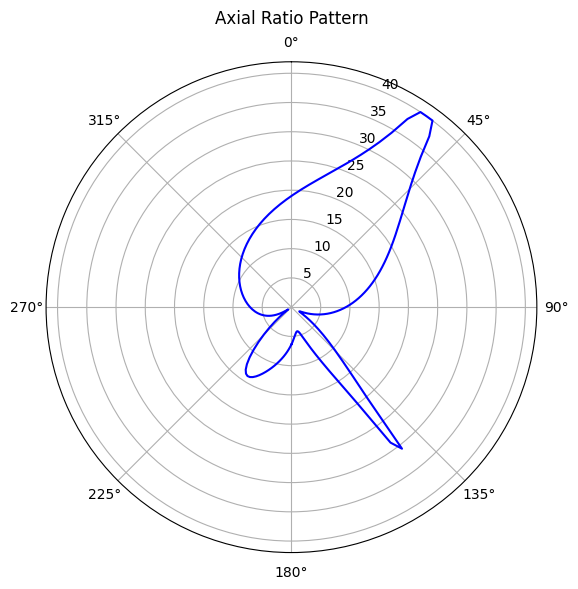

In [14]:
# Extract axial ratio
AxialRatio = sim_data["radiation"].axial_ratio.sel(f=freqs_target[0], phi=0, method="nearest")
AxialRatio = np.squeeze(AxialRatio)

# Create a single polar plot
fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax = fig.add_subplot(111, projection="polar")

# Plot axial ratio
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.plot(theta, log_value(AxialRatio), "-b", label="Tidy3D")
ax.set_title("Axial Ratio Pattern", va="bottom")

plt.show()

## Post processing: Left and Right polarized far field

Left polarization represents the counter-clockwise component of circularly polarized electric fields, calculated as:

$$
E_{\text{left}} = \frac{E_\theta - j E_\phi}{\sqrt{2}}
$$

while right polarization represents the clockwise component, calculated as:

$$
E_{\text{right}} = \frac{E_\theta + j E_\phi}{\sqrt{2}}
$$

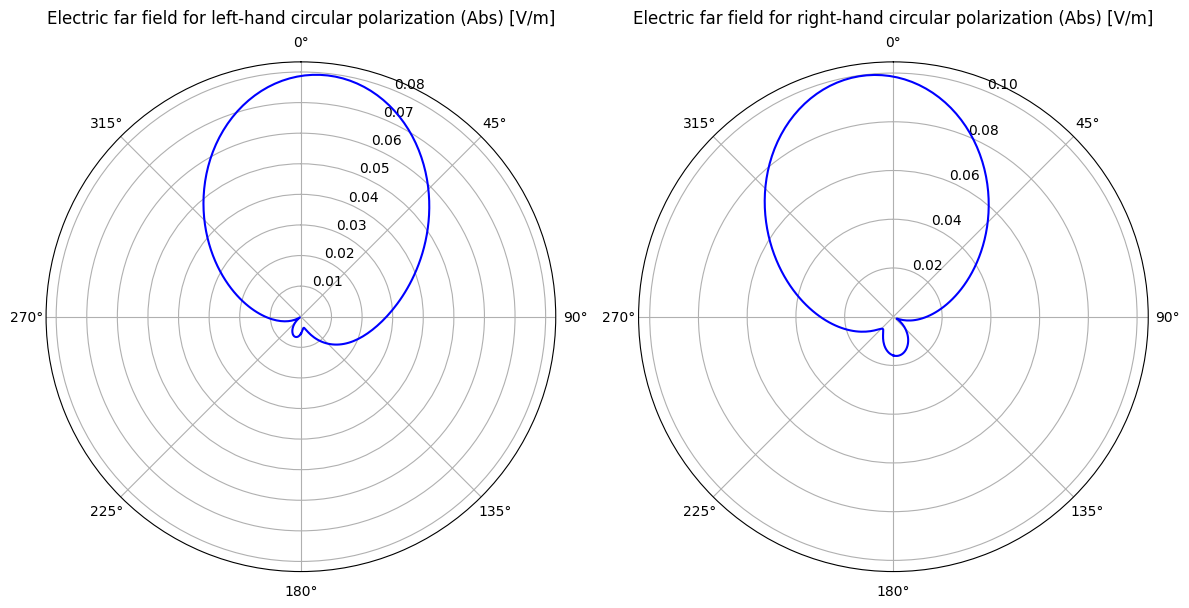

In [15]:
# Extract left polarization
left_polarization = abs(
    sim_data["radiation"].left_polarization.sel(f=freqs_target[0], phi=0, method="nearest")
)
left_polarization = np.squeeze(left_polarization)

# Extract right polarization
right_polarization = abs(
    sim_data["radiation"].right_polarization.sel(f=freqs_target[0], phi=0, method="nearest")
)
right_polarization = np.squeeze(right_polarization)

fig, (ax1, ax2) = plt.subplots(
    1, 2, subplot_kw={"projection": "polar"}, figsize=(12, 6), tight_layout=True
)

# Plot left polarization
ax1.set_theta_direction(-1)
ax1.set_theta_offset(np.pi / 2.0)
ax1.plot(theta, abs(left_polarization), "-b", label="Tidy3D")
ax1.set_title("Electric far field for left-hand circular polarization (Abs) [V/m]", va="bottom")

# Plot right polarization
ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2.0)
ax2.plot(theta, abs(right_polarization), "-b", label="Tidy3D")
ax2.set_title("Electric far field for right-hand circular polarization (Abs) [V/m]", va="bottom")

plt.show()

## Reference

[1] Sheen, D.M., Ali, S.M., Abouzahra, M.D. and Kong, J.A., 1990. Application of the three-dimensional finite-difference time-domain method to the analysis of planar microstrip circuits. IEEE Transactions on microwave theory and techniques, 38(7), pp.849-857.
